In [1]:
import json
from msi_visual.supervised.annotations import get_img, get_visualization, get_dataset
img = get_img("D:\maldi\slides\slide2_notol_5_bin\0.npy")
img2 = get_img("D:\maldi\slides\slide2_notol_5_bin\2.npy")
viz = get_visualization(r"C:\Users\Jacob Gildenblat\Desktop\maldi\app\visualizations\1_PercentileRatio.png")
viz2 = get_visualization(r"C:\Users\Jacob Gildenblat\Desktop\maldi\app\visualizations\0_PercentileRatio.png")
viz3 = get_visualization(r"C:\Users\Jacob Gildenblat\Desktop\maldi\app\visualizations\2_PercentileRatio.png")
img3 = get_img(1)
print(viz3.shape, img3.shape)


(248, 331, 3) (248, 331, 5255)


In [3]:

all_images = [img, img2]
X, y, label_encoder = get_dataset(r"expAI_NRL4489-s2_json.json", all_images, subsample=100)

NameError: name 'annotation_pathpath' is not defined

In [4]:
from xgboost import XGBClassifier

# Initialize and train XGBoost classifier
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=7,
    random_state=42,
    sample_weights=sample_weights,
    max_delta_step=1,  # Helps with class imbalance
    min_child_weight=5  # Helps prevent overfitting on minority classes
)


xgb_model.fit(X, y)

d:\miniconda3\envs\dl\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:55:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "sample_weights" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=1,
              max_depth=7, max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [4]:
import joblib
#joblib.dump(xgb_model, "xgb_model.pkl")
xgb_model = joblib.load("xgb_model.pkl")


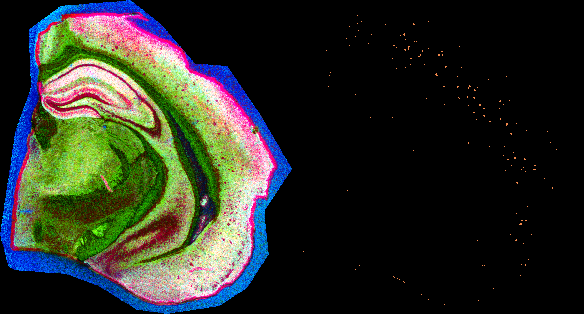

In [86]:
rotated = img2.transpose().transpose(1, 2, 0)[::-1, :, :]
viz_rotated = viz2.transpose(1, 0, 2)[::-1, :, :]


img_reshaped = rotated.reshape(-1, rotated.shape[-1])
pred = xgb_model.predict(img_reshaped)



pred_reshaped = pred.reshape(rotated.shape[:2])

# Create a colorful visualization of the predicted labels
viz_pred = np.zeros((*pred_reshaped.shape, 3), dtype=np.uint8)
# Assign different colors to each label
for label in np.unique(pred_reshaped):
    if label != 59:
        continue
    # Generate unique colors for each label using the same formula as before
    color = (((label + 1) * 4) % 255, ((label + 1) * 100) % 255, ((label + 1) * 150) % 255)
    color = np.uint8(color)
    # Create mask for current label and apply color
    label_mask = (pred_reshaped == label)
    viz_pred[label_mask] = color



viz_pred[rotated.max(axis=-1) == 0] = 0

both = np.hstack([viz_rotated, viz_pred])

display(Image.fromarray(both))

In [87]:
# Create histogram of plaque areas
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
%matplotlib inline


plaques_mask = (viz_pred > 0).max(axis=-1)


# Label connected regions in the mask
labeled_mask = label(plaques_mask)


# Get properties of each region
regions = regionprops(labeled_mask)


plaque_features = []
plaque_areas = []


for index in np.unique(labeled_mask):
    if index == 0:
        continue
    
    plaque_mask = (labeled_mask==index)
    
    f = rotated[plaque_mask > 0].mean(axis=0)
    
    plaque_features.append(f)
    plaque_areas.append(regions[index-1].area)

plaque_features = np.array(plaque_features)
print(plaque_features.shape, len(plaque_areas))



# # # Create UMAP embedding
# import umap
# import matplotlib.pyplot as plt

# # Initialize UMAP
# reducer = umap.UMAP(n_neighbors=30, min_dist=0.9, random_state=42, metric='chebyshev')

# # Fit and transform the data
# embedding = reducer.fit_transform(plaque_features)

# # Create scatter plot
# plt.figure(figsize=(10, 8))
# scatter = plt.scatter(embedding[:, 0], embedding[:, 1], 
#                      c=plaque_areas, 
#                      cmap='viridis',
#                      alpha=0.6)

# plt.colorbar(scatter, label='Plaque Area')
# plt.title('UMAP Projection of Plaque Features 2.npy')
# plt.xlabel('UMAP 1')
# plt.ylabel('UMAP 2')
# plt.show()



(125, 5255) 125


In [88]:
# Create UMAP embedding
import umap
import matplotlib.pyplot as plt
# Initialize PCA
from sklearn.decomposition import PCA
reducer = PCA(n_components=3, random_state=42)
# Fit and transform the data
embedding = reducer.fit_transform(plaque_features)

# # Create scatter plot
# plt.figure(figsize=(10, 8))
# scatter = plt.scatter(embedding[:, 0], embedding[:, 1], 
#                      c=plaque_areas, 
#                      cmap='viridis',
#                      alpha=0.6)

# plt.colorbar(scatter, label='Plaque Area')
# plt.title('PCA Projection of Plaque Features 1.npy')
# plt.xlabel('PCA 1')
# plt.ylabel('PCA 2')
# plt.show()



(125, 3) 126


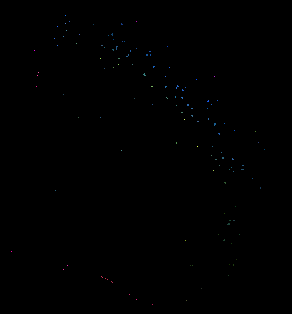

In [89]:
print(embedding.shape, len(np.unique(labeled_mask)))


draw = np.zeros((*rotated.shape[:2], 3), dtype=np.uint8)

embedding_uint = embedding - embedding.min(axis=0)
embedding_uint /= embedding_uint.max(axis=0)
embedding_uint *= 255
embedding_uint = embedding_uint.astype(np.uint8)

for i in np.unique(labeled_mask):
    if i == 0:
        continue
    
    draw[(labeled_mask == i )] = embedding_uint[i - 1]


Image.fromarray(draw)



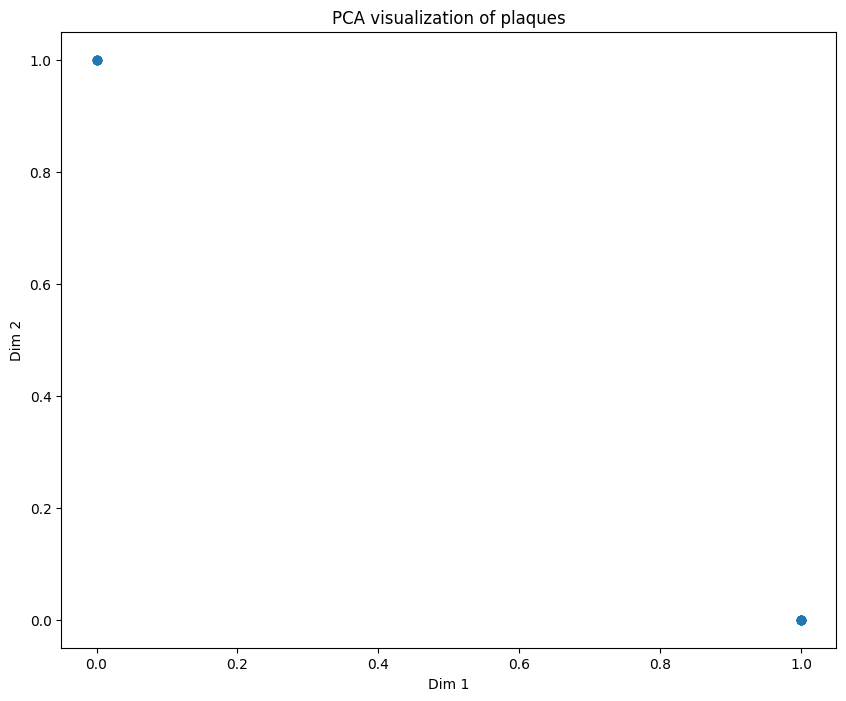

In [154]:
#viz_new = get_visualization(r"C:\Users\Jacob Gildenblat\Desktop\maldi\app\visualizations\0_MSINonParametricUMAPmin_dist_0.5n_neighbors_100metric_chebyshev.png")
#viz_new = get_visualization(r"C:\Users\Jacob Gildenblat\Desktop\maldi\mouse_brain_comprehensive_benchmark_large\2_PCA3D_eq.png")
viz_new = get_visualization(r"C:\Users\Jacob Gildenblat\Desktop\maldi\mouse_brain_comprehensive_benchmark_large\2_TSNE3D_eq.png")
X_new, y_new, label_encoder_new = get_dataset([img2], indices=[2], subsample=10, average=True)


y_new = np.array(y_new)
y_new = (y_new == label_encoder_new.transform(["plaque"])[0])

X_new = X_new[y_new == 1]


import umap
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
reducer = PCA(n_components=2, random_state=42)
#reducer = umap.UMAP(n_neighbors=30, min_dist=0.9, random_state=42, metric='chebyshev')
#reducer = umap.UMAP(n_neighbors=4, min_dist=0.5, random_state=42)
embedding = reducer.fit_transform(X_new)

embedding = embedding - embedding.min(axis=0)
embedding /= embedding.max(axis=0)


# Create 3D scatter plot
fig = plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1])
plt.title('PCA visualization of plaques')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2') 
plt.show()





In [8]:
import shap

# Create the SHAP explainer
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X)

# Print shape of SHAP values to verify dimensions
print(np.array(shap_values).shape)


(649, 5255, 60)


In [27]:
from msi_visual.extraction import get_extraction_mz_list
extraction_mzs = get_extraction_mz_list(r"D:\maldi\slides\slide2_notol_5_bin")

meanabs = np.abs(shap_values).max(axis=0)
[extraction_mzs[i] for i in np.argsort(meanabs[:, 59])[-20 :]]

[1185.0,
 1324.4,
 487.2,
 794.6,
 349.4,
 600.6,
 500.2,
 857.6,
 540.0,
 1327.0,
 965.6,
 1243.2,
 1166.0,
 1161.0,
 760.6,
 715.6,
 1165.0,
 885.6,
 1331.8,
 1179.8]

2024-11-09 12:59:22.215 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-09 12:59:22.218 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


setting ion 1185.0 1185.0


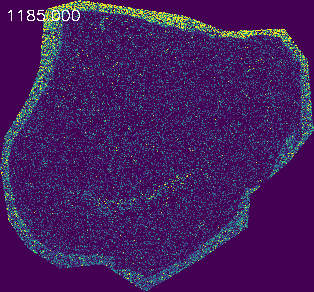

2024-11-09 12:59:22.518 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-09 12:59:22.520 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


setting ion 1324.4 1324.4


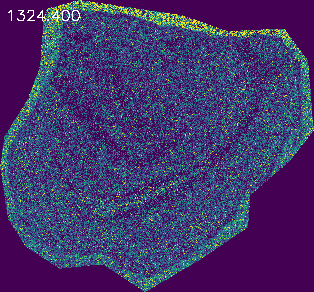

2024-11-09 12:59:23.298 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-09 12:59:23.301 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


setting ion 487.2 487.2


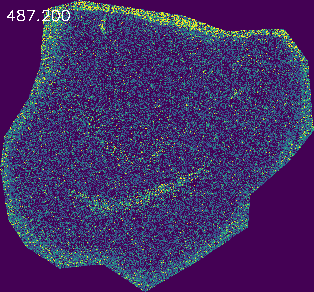

2024-11-09 12:59:23.712 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-09 12:59:23.715 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


setting ion 794.6 794.6


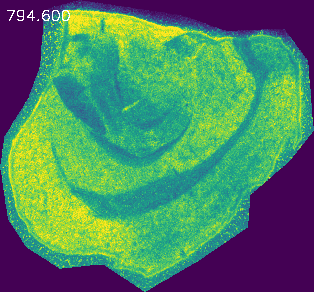

2024-11-09 12:59:23.832 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-09 12:59:23.834 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


setting ion 349.4 349.4


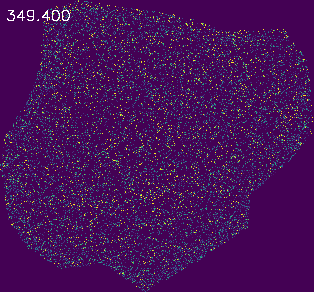

2024-11-09 12:59:24.099 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-09 12:59:24.101 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


setting ion 600.6 600.6


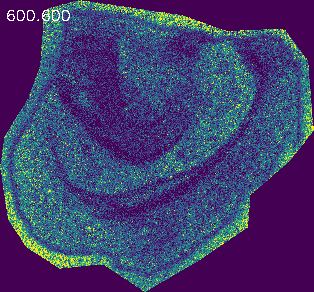

2024-11-09 12:59:24.195 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-09 12:59:24.198 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


setting ion 500.2 500.2


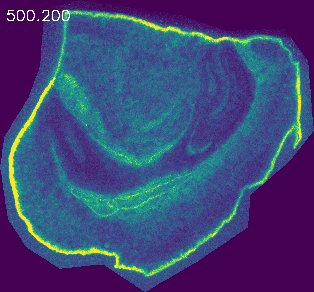

2024-11-09 12:59:24.386 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


setting ion 857.6 857.6


2024-11-09 12:59:24.389 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


2024-11-09 12:59:24.486 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-09 12:59:24.488 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


setting ion 540.0 540.0


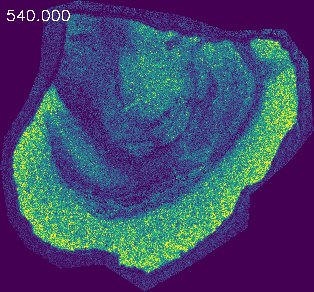

2024-11-09 12:59:24.579 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


setting ion 1327.0 1327.0


2024-11-09 12:59:24.582 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


2024-11-09 12:59:24.828 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-09 12:59:24.830 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


setting ion 965.6 965.6


2024-11-09 12:59:24.927 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-09 12:59:24.929 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


setting ion 1243.2 1243.2


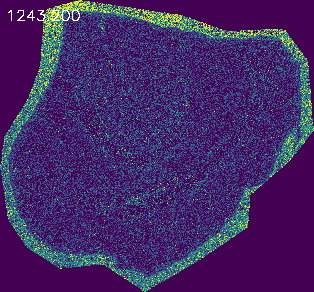

2024-11-09 12:59:25.051 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-09 12:59:25.053 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


setting ion 1166.0 1166.0


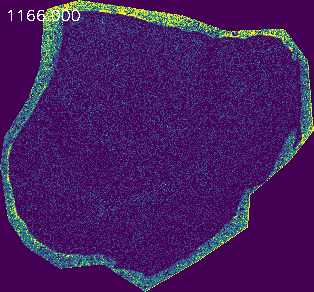

2024-11-09 12:59:25.141 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-09 12:59:25.143 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


setting ion 1161.0 1161.0


2024-11-09 12:59:25.238 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


setting ion 760.6 760.6


2024-11-09 12:59:25.242 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


2024-11-09 12:59:25.330 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


setting ion 715.6 715.6


2024-11-09 12:59:25.333 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


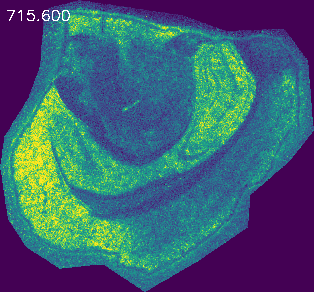

2024-11-09 12:59:25.432 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


setting ion 1165.0 1165.0


2024-11-09 12:59:25.435 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


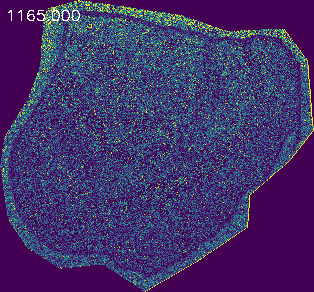

2024-11-09 12:59:25.538 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-09 12:59:25.540 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


setting ion 885.6 885.6


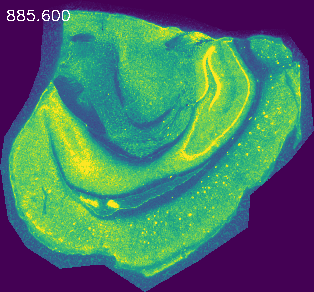

2024-11-09 12:59:25.634 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-09 12:59:25.637 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


setting ion 1331.8 1331.8


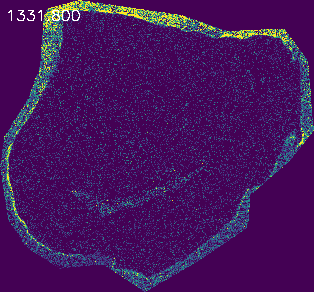

2024-11-09 12:59:25.729 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


setting ion 1179.8 1179.8


2024-11-09 12:59:25.732 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


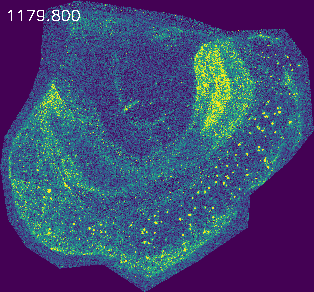

In [29]:
from msi_visual.app.utils.viewer import create_ion_image

top_mzs = [extraction_mzs[i] for i in np.argsort(meanabs[:, 59])[-20 :]]

for val in top_mzs:
    ion, mz = create_ion_image(img2,       val, extraction_mzs)
    display(Image.fromarray(ion))
